In [1]:
import pandas as pd
import seaborn as sns
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA
from pyspark.ml.stat import Correlation

# Year to investigate
# Year 2015 contains records from 2015 - 2022
YEAR = 2015


In [2]:
sc = SparkContext(appName="stack_exchange_pca")
sc.setLogLevel("ERROR")

23/02/12 22:53:11 WARN Utils: Your hostname, colyn-pc resolves to a loopback address: 127.0.1.1; using 192.168.68.110 instead (on interface wlp4s0)
23/02/12 22:53:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/02/12 22:53:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
spark = SparkSession.builder.getOrCreate()
data = spark.read.parquet("../metrics/metrics_questions_" + str(YEAR))

In [4]:
data.groupBy("target").count().show()

+------------+-------+
|      target|  count|
+------------+-------+
|  Unanswered|2586811|
|        null|4677443|
|BestAnswered|5736023|
+------------+-------+



In [5]:
data.printSchema()

root
 |-- _Score: double (nullable = true)
 |-- _ViewCount: double (nullable = true)
 |-- _AnswerCount: double (nullable = true)
 |-- _CommentCount: double (nullable = true)
 |-- _FavoriteCount: double (nullable = true)
 |-- _AcceptedAnswerId: integer (nullable = true)
 |-- FG: double (nullable = true)
 |-- FE: double (nullable = true)
 |-- CL: double (nullable = true)
 |-- CP: double (nullable = true)
 |-- CSPT: double (nullable = true)
 |-- CSTT: double (nullable = true)
 |-- SENT: double (nullable = true)
 |-- target: string (nullable = true)



In [6]:
data = data.drop(data._AcceptedAnswerId)

In [7]:
numeric_variables = ['FG', 'FE', 'CL', 'CP', 'CSPT', 'CSTT', "SENT"]
#numeric_variables = ['FG', 'FE', 'CL', 'CP', 'CSPT', 'CSTT', "SENT", "_AnswerCount", "_ViewCount", "_FavoriteCount", "_CommentCount", "_Score"]
# Next, in order to train ML models in Spark later, we'll use the VectorAssembler to combine a given list of columns into a single vector column.
assembler = VectorAssembler(inputCols=numeric_variables, outputCol='features')
df = assembler.transform(data).select('features')



/home/colyn/miniconda3/envs/rapids-22.12/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


<AxesSubplot: >

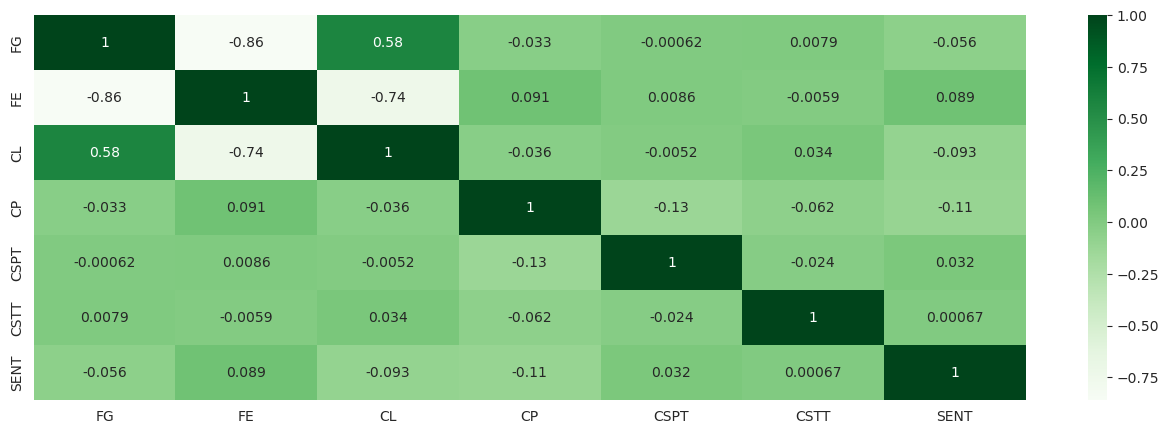

In [8]:
matrix = Correlation.corr(df, "features").collect()[0][0]

corr_matrix = matrix.toArray().tolist()
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = numeric_variables, index=numeric_variables)
plt.figure(figsize=(16,5))
sns.heatmap(corr_matrix_df,
            xticklabels=corr_matrix_df.columns.values,
            yticklabels=corr_matrix_df.columns.values,  cmap="Greens", annot=True)

In [36]:

# Next, we standardize the features, notice here we only need to specify the assembled column as the input feature
scaler = StandardScaler(
    inputCols=['target', 'features'],
    outputCol='scaledFeatures',
    withMean=True,
    withStd=True
).fit(df)

df_scaled = scaler.transform(df)
# After the preprocessing step, we fit the PCA model.
n_components = 7
pca = PCA(
    k=n_components,
    inputCol='scaledFeatures',
    outputCol='pcaFeatures'
).fit(df_scaled)

df_pca = pca.transform(df_scaled)
print('Explained variance Ratio', pca.explainedVariance.toArray())

TypeError: __init__() got an unexpected keyword argument 'inputCols'

[0.3540465355921558,0.16983744754968222,0.14547121561873166,0.1367835890071273,0.11741988086264443,0.061677971538802764,0.014763359830855877]


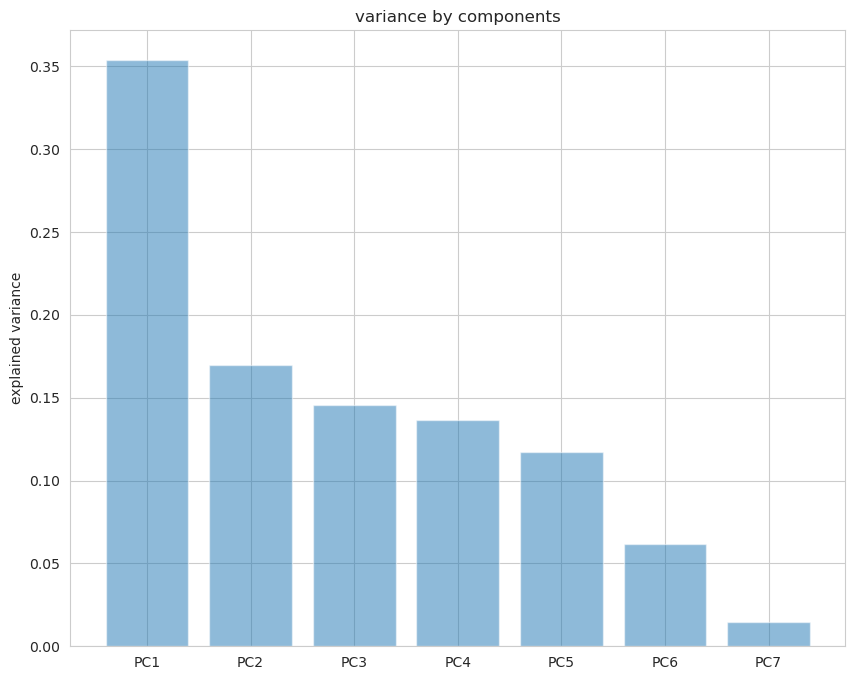

DenseMatrix([[-5.71353491e-01,  2.28351612e-03,  3.13315563e-02,
              -7.75313152e-02,  7.61714630e-02, -5.81766044e-01,
              -5.67717694e-01],
             [ 6.11000982e-01, -1.71473532e-02, -2.11812429e-02,
               4.86774309e-02, -2.23175579e-03,  1.48743333e-01,
              -7.75523095e-01],
             [-5.37309418e-01, -1.96366701e-02, -1.41625929e-02,
              -3.55454762e-03,  4.86439385e-02,  7.97149801e-01,
              -2.69973588e-01],
             [ 5.75659100e-02, -6.84617713e-01,  1.02400790e-01,
              -5.73433753e-02,  7.15226553e-01, -2.69579906e-03,
               5.15196932e-02],
             [ 2.92257761e-03,  5.27242479e-01,  4.18043148e-01,
               5.55625118e-01,  4.88230553e-01, -6.73962992e-04,
               1.25679761e-02],
             [-2.01363900e-02,  1.55314515e-01, -9.01439144e-01,
               2.67302016e-01,  2.99634069e-01, -3.81396157e-02,
               1.39220436e-02],
             [ 8.83387133e-0

In [10]:
import numpy as np
loadedPca = pca
loadedPca.getK()
objects = ('PC1', 'PC2','PC3','PC4','PC5','PC6','PC7')
print(loadedPca.explainedVariance)
cumValues = loadedPca.explainedVariance.cumsum()
plt.figure(figsize=(10,8))
ypos = np.arange(len(loadedPca.explainedVariance.toArray()))
#plt.plot(range(1,8), loadedPca.explainedVariance, marker='o')
plt.bar(ypos, loadedPca.explainedVariance, align='center', alpha=0.5)
plt.xticks(ypos, objects)
plt.title('variance by components')
plt.ylabel('explained variance')
plt.show()
print(loadedPca.pc)

In [11]:
print(loadedPca.pc.toArray()[0] )

[-0.57135349  0.00228352  0.03133156 -0.07753132  0.07617146 -0.58176604
 -0.56771769]


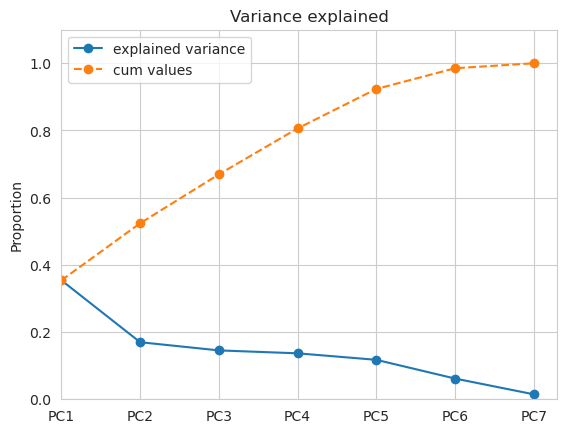

In [12]:
cumValues = loadedPca.explainedVariance.cumsum()
objects = ('PC1', 'PC2','PC3','PC4','PC5','PC6','PC7')
ypos = np.arange(len(loadedPca.explainedVariance.toArray()))
plt.plot(range(1,8), loadedPca.explainedVariance, marker='o')
plt.plot(range(1,8), cumValues, marker='o', linestyle='dashed')
#plt.bar(ypos, loadedPca.explainedVariance, align='center', alpha=0.5)
plt.legend(['explained variance','cum values'])
plt.ylim(0,1.1)
plt.xlim(len(cumValues))
plt.xticks(range(1,8), objects)
plt.title('Variance explained')
plt.ylabel('Proportion')
plt.show()

In [13]:
pca.save("pca_2015_1")

Py4JJavaError: An error occurred while calling o180.save.
: java.io.IOException: Path pca_2015_1 already exists. To overwrite it, please use write.overwrite().save(path) for Scala and use write().overwrite().save(path) for Java and Python.
	at org.apache.spark.ml.util.FileSystemOverwrite.handleOverwrite(ReadWrite.scala:683)
	at org.apache.spark.ml.util.MLWriter.save(ReadWrite.scala:167)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)


In [35]:
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, DoubleType

transformed_features = df_pca.select("pcaFeatures")
def split_array_to_list(col):
    def to_list(v):
        return v.toArray().tolist()
    return udf(to_list, ArrayType(DoubleType()))(col)

# only selects PC1 and PC2
transformed_features = transformed_features.select(split_array_to_list(col("pcaFeatures")).alias("pc")) \
    .select([col("pc")[i] for i in range(7)])
print(transformed_features.count())

labels = data.select("target")
print(labels.count())

transformed_dataset = transformed_features.withColumn('target', labels.target)
transformed_dataset.printSchema()
print(df_pca.count())
transformed_dataset = transformed_dataset.na.fill("Answered", subset=["target"])
transformed_features = df_pca.take(10000)
print(transformed_dataset.count())


13000277
13000277


AnalysisException: Resolved attribute(s) target#13 missing from pc[0]#1317,pc[1]#1318,pc[2]#1319,pc[3]#1320,pc[4]#1321,pc[5]#1322,pc[6]#1323 in operator !Project [pc[0]#1317, pc[1]#1318, pc[2]#1319, pc[3]#1320, pc[4]#1321, pc[5]#1322, pc[6]#1323, target#13 AS target#1350].;
!Project [pc[0]#1317, pc[1]#1318, pc[2]#1319, pc[3]#1320, pc[4]#1321, pc[5]#1322, pc[6]#1323, target#13 AS target#1350]
+- Project [pc#1315[0] AS pc[0]#1317, pc#1315[1] AS pc[1]#1318, pc#1315[2] AS pc[2]#1319, pc#1315[3] AS pc[3]#1320, pc#1315[4] AS pc[4]#1321, pc#1315[5] AS pc[5]#1322, pc#1315[6] AS pc[6]#1323]
   +- Project [to_list(pcaFeatures#163) AS pc#1315]
      +- Project [pcaFeatures#163]
         +- Project [features#71, scaledFeatures#152, UDF(scaledFeatures#152) AS pcaFeatures#163]
            +- Project [features#71, UDF(features#71) AS scaledFeatures#152]
               +- Project [features#71]
                  +- Project [_Score#0, _ViewCount#1, _AnswerCount#2, _CommentCount#3, _FavoriteCount#4, FG#6, FE#7, CL#8, CP#9, CSPT#10, CSTT#11, SENT#12, target#13, UDF(struct(FG, FG#6, FE, FE#7, CL, CL#8, CP, CP#9, CSPT, CSPT#10, CSTT, CSTT#11, SENT, SENT#12)) AS features#71]
                     +- Project [_Score#0, _ViewCount#1, _AnswerCount#2, _CommentCount#3, _FavoriteCount#4, FG#6, FE#7, CL#8, CP#9, CSPT#10, CSTT#11, SENT#12, target#13]
                        +- Relation [_Score#0,_ViewCount#1,_AnswerCount#2,_CommentCount#3,_FavoriteCount#4,_AcceptedAnswerId#5,FG#6,FE#7,CL#8,CP#9,CSPT#10,CSTT#11,SENT#12,target#13] parquet


In [ ]:
len_t = transformed_dataset.count()
# Take only 1000 samples for the plot randomly
fraction = 1000 / len_t
print(fraction)
#t = transformed_dataset.take(100)
#transformed_dataset_s = transformed_dataset.sample(fraction, 1, withReplacement=False)

#transformed_dataset.plot.scatter(x='pc[1]', y='pc[2]', c='target')
# Tidy up plot
# plt.legend(loc=0, fontsize=15)
# plt.margins(0.05)
# plt.xlabel('PCA 1')
# plt.ylabel('PCA 2')

In [ ]:
pc1 = t.select("pc[1]").toPandas()
pc2 = t.select("pc[2]").toPandas()
plt.scatter(pc1, pc2, c='target')